In [1]:
from solver import classic_solver
from aspen import aspen_solver
import partion
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  
%load_ext autoreload
%autoreload 2

### Начальные условия и модель

In [2]:
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

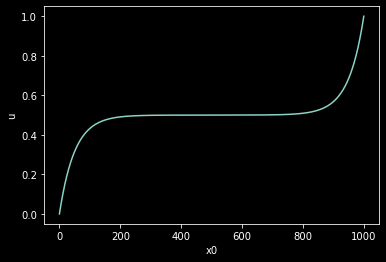

In [3]:
plt.style.use('dark_background')
# inital condition
Nx = 1000
Nt = 100

D = Diffusion(Nx, 0.9, 1, 0.5e-1, model=model)
bd1 = 0
bd2 = 1

x0 = np.arange(Nx)/(Nx-1)
x0 = np.sinh(20*(x0-0.5))
x0 /= np.max(x0)
x0 = (x0+1)/2
x0 = np.reshape(x0, (-1, 1))
plt.xlabel('x0')
plt.ylabel('u')
plt.plot(x0)

setInitial = lambda x: x#.setInitial(0.2, 1, 1) 
setSources = lambda x: x#.setSources([0.9], [-17.9])

Такое начальное условие выбрано для динамики, позднее на графиках будет видно как решение меняется по времени

In [4]:
param = {
    'Nx': Nx, 
    'Nt': Nt,
}
solver_cl = classic_solver(param, D)
solver_cl.setBoundary(bd1, bd2)
solver_cl.x0 = np.copy(x0)
#setInitial(solver_cl)
setSources(solver_cl)

X_cl, code, message = solver_cl.solve()
print(message)
print('mean newton iterations: ', np.mean(solver_cl.timelog.kn))

OK
mean newton iterations:  4.57


In [5]:
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt,
    'Nd': Nd
}

part = partion.partion_equally
solver_as = aspen_solver(param, D, part)
solver_as.setBoundary(bd1, bd2)
solver_as.x0 = np.copy(x0)
#setInitial(solver_as)
setSources(solver_as)

X, code, message = solver_as.solve()
print(message)
print('mean aspen iterations: ', np.mean(solver_as.timelog.aspen_iters))

OK
mean aspen iterations:  1.02


### Графики решения

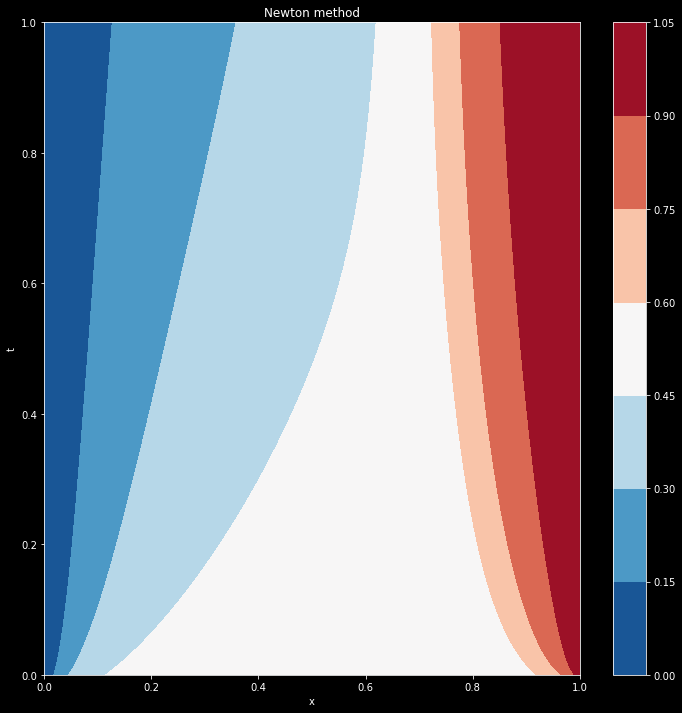

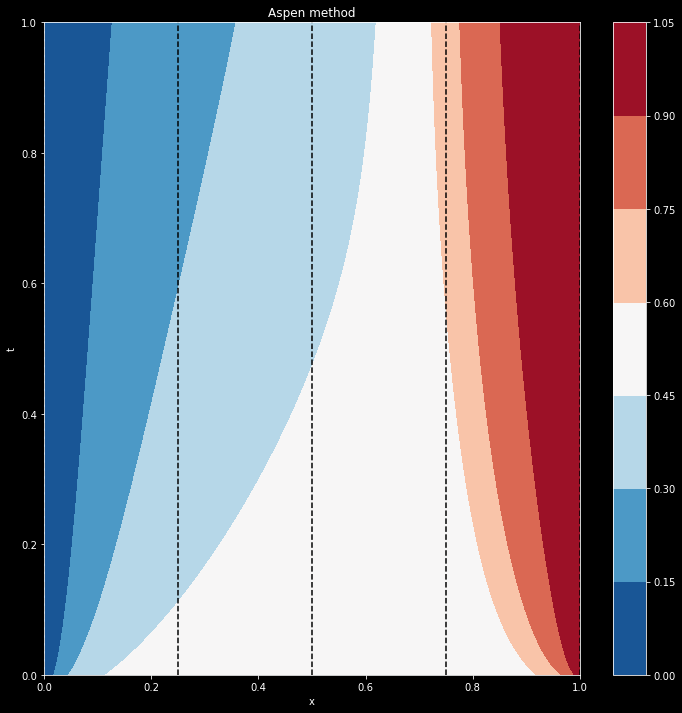

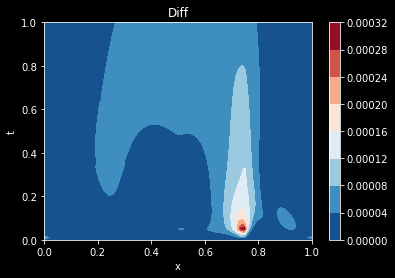

In [6]:
x = np.linspace(0, 1, Nx)

plt.figure(figsize= (12, 12))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Newton method')
t = solver_cl.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, X_cl.T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
plt.show()

plt.figure(figsize= (12, 12))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Aspen method')
t = solver_as.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, X.T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
# plot domain borders
part = partion.partion_equally(Nx, Nd)
for dom in part:
    plt.axvline(dom/Nx, linestyle='--', color='k')

plt.show()

plt.title('Diff')
plt.xlabel('x')
plt.ylabel('t')
t = solver_as.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, (np.abs(X-X_cl)).T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
plt.show()

Как видим а) присутсвует динамика по времени, имеющая локальный характер, б) решения двух алгоритмов отличаются в пределах погрешности

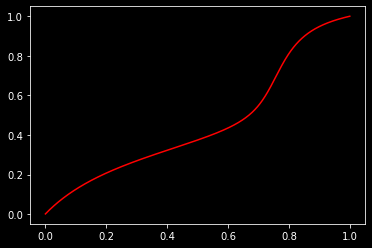

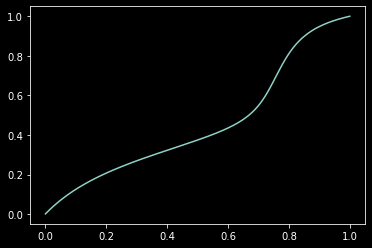

In [7]:
# optional, just to view results on step x

step = -2
plt.plot(x, X_cl[:, step], color = 'r')
plt.show()
plt.plot(x, X[:, step])
plt.show()

In [8]:
print('aspen/newton comparsion')
print('---global versus newton---')
print('gb_resbld = {}, resbld ={}'.format(solver_as.timelog.gb_resbld, solver_cl.timelog.resbld))
print('gb_jacbld = {}, jacbld = {}'.format(solver_as.timelog.gb_jacbld, solver_cl.timelog.jacbld))
print('gb_linsol = {}, linsol = {}'.format(solver_as.timelog.gb_linsol, solver_cl.timelog.linsol))
print('---local+global time vs newton time---')
t1 = solver_as.timelog.gb_resbld+solver_as.timelog.gb_jacbld \
      +solver_as.timelog.gb_linsol+np.sum(solver_as.timelog.lc_resbld) \
      +np.sum(solver_as.timelog.lc_jacbld)+np.sum(solver_as.timelog.lc_linsol)
t2 = solver_cl.timelog.resbld+solver_cl.timelog.jacbld \
      +solver_cl.timelog.linsol
print('aspen = {}, newton = {}'.format(t1, t2))

aspen/newton comparsion
---global versus newton---
gb_resbld = 5.40973162651062, resbld =12.865233182907104
gb_jacbld = 5.881465911865234, jacbld = 22.529091835021973
gb_linsol = 2.499174118041992, linsol = 8.514301061630249
---local+global time vs newton time---
aspen = 32.62478542327881, newton = 43.908626079559326


Ура! Наконец-то получилось добиться весомого ускорения. Давайте разбираться почему

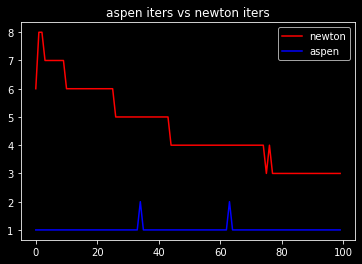

In [9]:
plt.title('aspen iters vs newton iters')
plt.plot(solver_cl.timelog.kn, color = 'r', label='newton')
plt.plot(solver_as.timelog.aspen_iters, color = 'b', label='aspen')
plt.legend()
plt.show()

Почти везде aspen справляется за одну иттерацию, когда метод Ньютона работает долго на начальных этапах задачи. Скорей всего, продолжи мы решения даже, вышли бы уже на почти стационарный участоток, где мало требуется мало иттераций

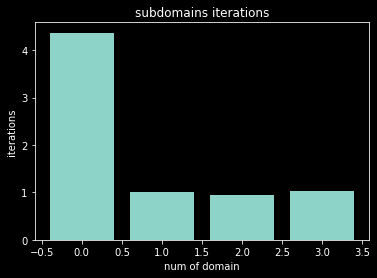

In [10]:
plt.title('subdomains iterations')
plt.xlabel('num of domain')
plt.ylabel('iterations')
plt.bar(np.arange(0, Nd, 1, dtype='int'), solver_as.timelog.domain_iters)
plt.show()

Среднее число иттераций в нулевом домене примерно соотвествует 
среднему числу иттераций в методе Ньютона. Похоже, что aspen работает засчет выделения как раз-таки таких участков

### Тактики разбиения
На примере данной задачи будем тестить разные критерии разбиения на домены

##### Метод 1
$$
w(v, u) = \frac{|\frac{\partial R(u)}{\partial v}| }{ | Rx(u)| }|v| +
\frac{ |\frac{\partial R(v)}{\partial u}| }{| Rx(v) |}|u|
$$

$$
	\sum_{i=1}^k \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} \frac{w(v, u)}{k} + \lambda \frac{\sum_{i=1}^k |V|/|V_i|}{k} \rightarrow min 
$$

In [18]:
def metrics_1(solver, X, domain_borders, Nt, t_step, lamb=20, show = False):
    nd = domain_borders.shape[0]-1
    reg = lamb/(nd-1)*np.sum(domain_borders[-1]/(domain_borders[1:] - domain_borders[:-1]))
    val = 0
    for n_t in range(0, Nt+1, t_step):
        for i in range(1, nd):
            bd = domain_borders[i]
            val += np.abs(solver.calcFluxJac(X[:, n_t], bd)[0, 1]) \
                / np.abs(solver.calcFluxRes(X[:, n_t], bd)[0] \
                         - solver.calcFluxRes(X[:, n_t], bd-1)[0]) \
                * np.abs(X[bd, n_t]) \
                +np.abs(solver.calcFluxJac(X[:, n_t], bd)[0, 0]) \
                / np.abs(solver.calcFluxRes(X[:, n_t], bd+1)[0] \
                         - solver.calcFluxRes(X[:, n_t], bd)[0]) \
                * np.abs(X[bd-1, n_t])

        #val /= (nd-1)
    val /= ((Nt+1)//t_step)
    if(show):
        print(val, reg)
    return val+reg

def neighbour(domain_borders):
    nd = domain_borders.shape[0]-1
    neig = np.copy(domain_borders)
    for i in range(1, nd):
        bd = neig[i]
        left = (bd-1 != neig[i-1])
        right = (bd+1 != neig[i+1])
        
        if left and right:
            neig[i] += np.random.randint(-1, 1)
        elif left:
            neig[i] += np.random.randint(-1, 0)
        elif right:
            neig[i] += np.random.randint(0, 1)
            
    return neig

In [27]:
# start value
part = partion.partion_equally(Nx, Nd)
print(part)
borders = np.copy(part)

T0 = 19600
val_start = metrics_1(solver_cl, X, borders, Nt, 1, show=True)
val_prev = np.copy(val_start)
for k in range(0, 220, 1):
    T = T0/(1.1**k)
    borders_new = neighbour(borders)
    val = metrics_1(solver_cl, X, borders_new, Nt, 1)
    if (val < val_prev) or (np.random.rand() < np.exp(-(val-val_prev)/(100*T))):
        borders = np.copy(borders_new)
        val_prev = np.copy(val)
        
val_end = metrics_1(solver_cl, X, borders, Nt, 1, show=True)
print('before: {:.2f}'.format(val_start))
print('after: {:.2f}'.format(val_end))
if(val_start > val_end):
    print('it works!')
print(borders)

[   0  250  500  750 1000]
3953737.622031678 106.66666666666667
1464163.5318161328 111.93926642682771
before: 3953844.29
after: 1464275.47
it works!
[   0  169  422  714 1000]


In [28]:
def new_partion(Nx, Nd):
    return borders

print(borders)
Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt,
    'Nd': Nd
}

new_part = new_partion
solver_new = aspen_solver(param, D, new_part)
solver_new.setBoundary(bd1, bd2)
solver_new.x0 = np.copy(x0)
#setInitial(solver_as)
setSources(solver_new)

X, code, message = solver_new.solve()
print(message)
print('mean aspen iterations: ', np.mean(solver_new.timelog.aspen_iters))

[   0  169  422  714 1000]
OK
mean aspen iterations:  1.17


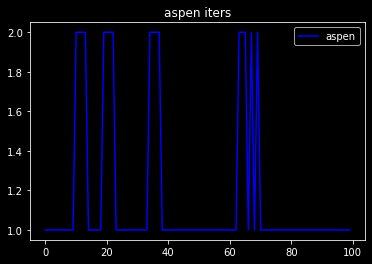

equally/metrics1 partions compare
---all time---
equally = 32.62478542327881, m1 = 31.525402784347534
subdomain time
---resbld---
eq [3.77612042 1.43617964 1.37712669 1.43530965]
m1 [2.54308248 1.49634695 1.72868133 1.71866965]
---jacbld---
eq [6.02905917 1.38762045 1.29562283 1.44392037]
m1 [3.9758532  1.38344193 1.56898952 1.59882665]
---linsol---
eq [0.38912296 0.08798885 0.08440828 0.09193444]
m1 [0.22809982 0.0935595  0.10511994 0.11129284]


In [124]:
plt.title('aspen iters')
plt.plot(solver_new.timelog.aspen_iters, color = 'b', label='aspen')
plt.legend()
plt.show()

print('equally/metrics1 partions compare')
print('---all time---')
t_eq = solver_as.timelog.gb_resbld+solver_as.timelog.gb_jacbld \
      +solver_as.timelog.gb_linsol+np.sum(solver_as.timelog.lc_resbld) \
      +np.sum(solver_as.timelog.lc_jacbld)+np.sum(solver_as.timelog.lc_linsol)
t_m1 = solver_new.timelog.gb_resbld+solver_new.timelog.gb_jacbld \
      +solver_new.timelog.gb_linsol+np.sum(solver_new.timelog.lc_resbld) \
      +np.sum(solver_new.timelog.lc_jacbld)+np.sum(solver_new.timelog.lc_linsol)
print('equally = {}, m1 = {}'.format(t_eq, t_m1))
print('subdomain time')
print('---resbld---')
print('eq', solver_as.timelog.lc_resbld)
print('m1', solver_new.timelog.lc_resbld)
print('---jacbld---')
print('eq', solver_as.timelog.lc_jacbld)
print('m1', solver_new.timelog.lc_jacbld)
print('---linsol---')
print('eq', solver_as.timelog.lc_linsol)
print('m1', solver_new.timelog.lc_linsol)

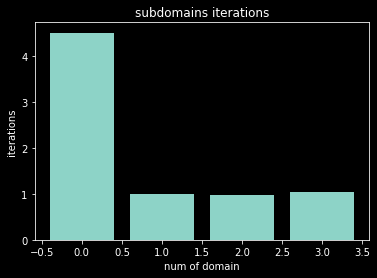

In [125]:
plt.title('subdomains iterations')
plt.xlabel('num of domain')
plt.ylabel('iterations')
plt.bar(np.arange(0, Nd, 1, dtype='int'), solver_new.timelog.domain_iters)
plt.show()

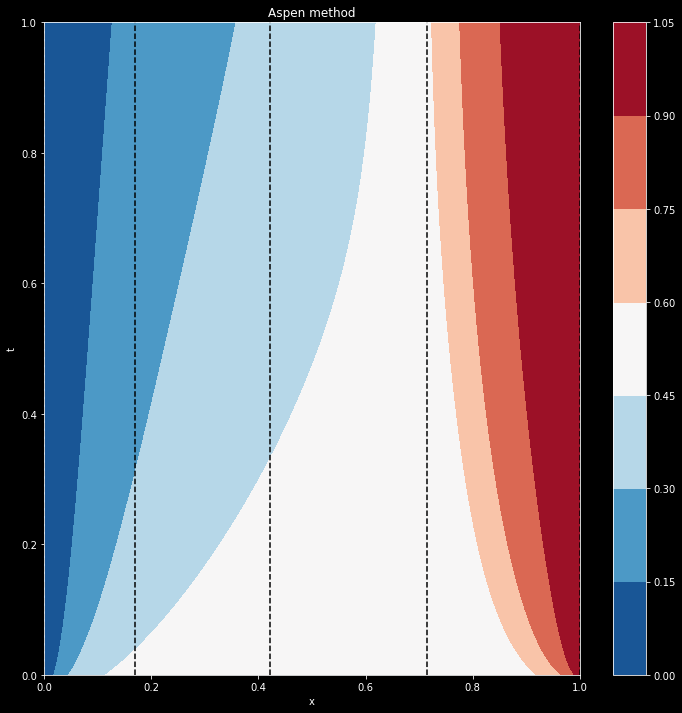

In [31]:
plt.figure(figsize= (12, 12))
plt.xlabel('x')
plt.ylabel('t')
plt.title('Aspen method')
t = solver_new.t
x_grid, t_grid = np.meshgrid(x, t)
cs = plt.contourf(x_grid, t_grid, X.T, cmap='RdBu_r')
cbar = plt.colorbar(cs)
# plot domain borders
part = borders
for dom in part:
    plt.axvline(dom/Nx, linestyle='--', color='k')

plt.show()

Какой можно сделать вывод: данная метрика стремитя локализовать область с наибольшим число иттераций (почему?). А еще можно заметить, что введеная регуляризация не работает вообще (изменилась от силы на 4 %)

##### Тест на рандомных границах

In [69]:
def generate_random(Nx, Nd, min_size=10):
    size = 0
    while(size < min_size):
        choice = 10+np.random.choice(Nx-10, Nd-1)
        choice = np.sort(choice)
        size = np.min(choice[1:] - choice[:-1])
    return np.concatenate(([0], choice , [Nx]), axis = 0)

In [132]:
N = 150

Nd = 4
param = {
    'Nx': Nx, 
    'Nt': Nt,
    'Nd': Nd
}

part = generate_random

time = np.zeros(N)
num_of_alghs = 0

for k in range(N):
    solver_ts = aspen_solver(param, D, part)
    solver_ts.setBoundary(bd1, bd2)
    solver_ts.x0 = np.copy(x0)
    #setInitial(solver_as)
    setSources(solver_ts)

    _, _, message = solver_ts.solve()
    if(message != 'OK'):
        continue
    t = solver_ts.timelog.gb_resbld+solver_ts.timelog.gb_jacbld \
      +solver_ts.timelog.gb_linsol+np.sum(solver_ts.timelog.lc_resbld) \
      +np.sum(solver_ts.timelog.lc_jacbld)+np.sum(solver_ts.timelog.lc_linsol)
    time[k] = t
    num_of_alghs += 1

In [160]:
print('Numner og alghorithms that converged:', num_of_alghs)
print('mean time :', np.sum(time)/num_of_alghs)
sq_cov = np.sqrt(np.sum(time**2)/num_of_alghs-(np.sum(time)/num_of_alghs)**2)
print('sqrt cov :', np.sqrt(np.sum(time**2)/num_of_alghs-(np.sum(time)/num_of_alghs)**2))

Numner og alghorithms that converged: 136
mean time : 69.2715382488335
sqrt cov : 152.69964434101155


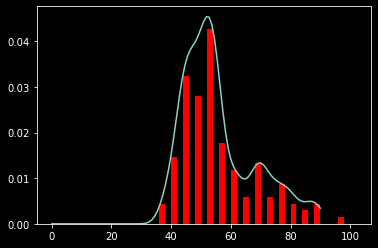

In [178]:
from scipy.stats import gaussian_kde
from scipy.integrate import quad

width = 4
win = np.arange(5, 105, width)
y = []
for x in win:
    mask = ((time < x+width/2) & (time > (x - width/2)))
    y.append(np.sum(mask)/ num_of_alghs/5)
    
plt.bar(win, y, width=width*0.5, color = 'r')
bw = 1/(1.06*sq_cov)*num_of_alghs**(1/5)
time = time[time > 0]
kernel = gaussian_kde(time, bw_method=bw)

plt.plot(np.linspace(0, 90, 100), kernel(np.linspace(0, 90, 100)))
plt.show()

In [180]:
# we will estimate the efficency by function of distibution

p_eq, err_eq = quad(kernel, 0, t_eq)
print('equally partion : {}'.format(p_eq))
p_m1, err_m1 = quad(kernel, 0, t_m1)
print('m1 partion : {}'.format(p_m1))

equally partion : 0.0004154567756711655
m1 partion : 0.0001287783808096175


In [191]:
import csv

name = 'Nx={},Nt={},Nd={}.csv'.format(Nx, Nt, Nd)

with open(name, 'a') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(time)